## **Implementing Connectivity**

In [ ]:
from keras.layers import Dense, Embedding, Input, LSTM, GRU, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.models import Sequential
from keras.utils import np_utils
from tensorflow import keras
from keras import layers
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import re

#Imports for visualisations
from IPython.display import HTML as html_print
from IPython.display import display
import keras.backend as K

#To load model
from keras.models import model_from_json
import h5py
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def download_unzip():
    !wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
    !tar -xf dakshina_dataset_v1.0.tar
download_unzip()

--2021-05-20 00:13:14--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar.1’

dakshina_dataset_v1 100%[===================>]   1.87G   150MB/s    in 14s     

2021-05-20 00:13:28 (135 MB/s) - ‘dakshina_dataset_v1.0.tar.1’ saved [2008340480/2008340480]



In [ ]:
train_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_path =   "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"
num_samples = 50000

In [ ]:
max_encoder_seq_length = 0
max_decoder_seq_length = 0
num_encoder_tokens     = 0
num_decoder_tokens     = 0
input_token_index      = {}
arget_token_index      = {}
input_characters       = set()
target_characters      = set()
def Vectorize_Data(Data_path, isTrain):

  global input_characters, target_characters,  num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length, input_token_index, target_token_index
  input_texts       = []
  target_texts      = []
  input_characters  = set()
  target_characters = set()
  with open(Data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[: min(num_samples, len(lines) - 1)]:
    target_text, input_text, _ = line.split("\t")
    target_text = " " + target_text + " "
    input_text  = " " + input_text + " "
    input_texts.append(input_text)
    target_texts.append(target_text)
    if isTrain:
      for char in input_text:
          if char not in input_characters:
              input_characters.add(char)
      for char in target_text:
          if char not in target_characters:
              target_characters.add(char)
  if isTrain:
    input_characters       = sorted(list(input_characters))
    target_characters      = sorted(list(target_characters))
    num_encoder_tokens     = len(input_characters)
    num_decoder_tokens     = len(target_characters)
    max_encoder_seq_length = max([len(txt) for txt in input_texts])+1
    max_decoder_seq_length = max([len(txt) for txt in target_texts])+1

    input_token_index  = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

  encoder_input_data  = np.zeros((len(input_texts), max_encoder_seq_length), dtype = "float32")
  decoder_input_data  = np.zeros((len(input_texts), max_decoder_seq_length), dtype = "float32")
  decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype = "float32")

  for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t]   =  input_token_index[char]
      encoder_input_data[i, t + 1 :] = input_token_index[" "]
      for t, char in enumerate(target_text):
          decoder_input_data[i, t]   = target_token_index[char]
          if t > 0:
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_input_data[i, t + 1 :] = target_token_index[" "]
      decoder_target_data[i, t:, target_token_index[" "]] = 1.0

  return input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data

## Loading Model and Weights from Google Drive

---

In [ ]:
#Load and create model
json_file = open('/content/drive/MyDrive/DL_Assignment 3/model_beam_attn.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

#Load weights into new model
model.load_weights("/content/drive/MyDrive/DL_Assignment 3/model_beam_attn.hdf5")

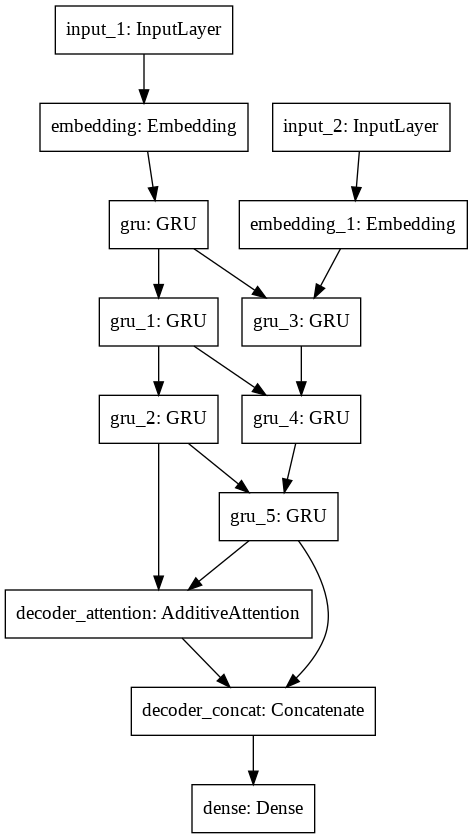

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data = Vectorize_Data(train_path, 1)
input_texts_test, target_texts_test, encoder_input_data_test, decoder_input_data_test, decoder_target_data_test = Vectorize_Data(test_path, 0)

In [ ]:
layer = model.get_layer('decoder_concat')

In [ ]:
model = tf.keras.Model(inputs=model.inputs, outputs=layer.output, name="decoder_concat"+"model")

In [ ]:
model.summary()

Model: "decoder_concatmodel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 23, 256)      6912        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 22, 256)      16384       input_2[0][0]                    
________________________________________________________________________________

In [ ]:
predictions = model.predict([encoder_input_data_test, decoder_input_data_test])
predictions.shape

(4502, 22, 256)

In [ ]:
predictions[0].shape

(22, 256)

In [ ]:
#Get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
#Print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

#Get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

In [ ]:
def sigmoid(x):return 1/(1 + np.exp(-x))

In [ ]:
def visualize(output_values, result_list, cell_no):
  print("\nCell Number:", cell_no, "\n")
  text_colours = []
  for i in range(len(output_values)):
    text = (result_list[i], get_clr(output_values[i][cell_no]))
    text_colours.append(text)
  print_color(text_colours)

#Get Predictions from random sequence
def get_predictions(data):
  
  start = 0
  pattern = []
  pattern.append(data[start])
  result_list, output_values = [], []
  
  for prediction in data:

    result = 0    
    #Predicted Character
    output = sigmoid(prediction)
    index = np.argmax(prediction)
    output_values.append(output)
    for k, v in target_token_index.items():
      if v == index:
        result = k
    
    #Preparing input for next character
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
    
	  #Saving generated characters
    result_list.append(result)
  return output_values, result_list

In [ ]:
cell_set = random.sample(range(0, 256), 5)
print(cell_set)
for i in range(100, 110):
  output_values, result_list = get_predictions(predictions[i])
  print("\nTest word: ", i)
  for cell_no in cell_set:
	  visualize(output_values, result_list, cell_no)

[185, 73, 38, 41, 228]

Test word:  100

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  101

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  102

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  103

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  104

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  105

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  106

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  107

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  108

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 




Test word:  109

Cell Number: 185 




Cell Number: 73 




Cell Number: 38 




Cell Number: 41 




Cell Number: 228 

